In [1]:
from typing import Tuple, Callable, List
import random

import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import pandas as pd

# Windy gridworld

In [2]:
class WindyGridEnv:
    """Windy grid worl env from example 6.5"""
    def __init__(self,
                 dim: Tuple[int, int],
                 terminate: Tuple[int, int] = (3, 7),
                 start: Tuple[int, int] = (3, 0)):
        """
        Initialize env
        :param dim: grid dimension
        :param terminate: where to terminate episode
        :param start: where to start episode
        """
        self.dim = dim
        self.actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        self.state_terminate = self.grid_to_state(terminate)
        self.state_start = self.grid_to_state(start)
        self.wind_up = (0, 0, 0, 1, 1, 1, 2, 2, 1, 0)
        self.num_states = self.dim[0] * self.dim[1]
        
    def grid_to_state(self, pos: Tuple[int, int]) -> int:
        """from grid position to state"""
        return pos[1] + pos[0] * self.dim[1]
    
    def state_to_grid(self, state: int) -> Tuple[int, int]:
        """from state idx to grid position"""
        return state // self.dim[1], state % self.dim[1]
    
    def observe(self, state: int, action: int) -> Tuple[float, int]:
        """
        One envioronment observation, what happens when a ceratin action is taken in a certain state?
        :param state: current state
        :param action: action to take
        :return: a tuple (reward, next state idx, True is new state is the terminal one)
        """
        move_vert, move_hor = self.actions[action]
        current_pos = self.state_to_grid(state)
        next_pos = current_pos[0] + move_vert - self.wind_up[current_pos[1]], current_pos[1] + move_hor
        if next_pos[0] < 0:
            next_pos = 0, next_pos[1]
            
        if next_pos[1] < 0:
            next_pos = next_pos[0], 0
            
        if next_pos[0] >= self.dim[0]:
            next_pos = self.dim[0]-1, next_pos[1]
            
        if next_pos[1] >= self.dim[1]:
            next_pos = next_pos[0], self.dim[1]-1
            
        next_state = self.grid_to_state(next_pos)
        terminate = next_state == self.state_terminate
            
        return -1, next_state, terminate

Basic env testing

In [12]:
windy_env = WindyGridEnv(dim=(7, 10))
test_state = 5, 3
assert windy_env.state_to_grid(windy_env.grid_to_state(test_state)) == test_state
windy_env.observe(0, 0)

(-1, 0, False)

### SARSA
Define SARSA agent

In [6]:
class SarsaAgent:
    """Sarsa agent as in paragraph 6.4"""
    def __init__(self, alpha: float = .5, eps: float = .1, gamma: float = 1, num_episodes: int = 200):
        """
        Initialize agent
        :param alpha: step size
        :param eps: eps greedy parameter
        :param gamma: discount factor
        :param num_episodes: number of episodes
        """
        self.eps = eps
        self.gamma = gamma
        self.num_episodes = num_episodes
        self.alpha = alpha

    def policy(self, q: np.array) -> int:
        """eps greedy policy"""
        if random.uniform(0, 1) >= self.eps:
            action = self.argmax(q_values=q)
        else:
            action = random.randint(0, len(q)-1)
            
        return action
    
    def argmax(self, q_values):
        """argmax with random tie-breaking
        Args:
            q_values (Numpy array): the array of action-values
        Returns:
            action (int): an action with the highest value
        """
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return random.choice(ties)

    def solve(self, env: WindyGridEnv) -> Tuple[np.ndarray, np.array, List]:
        """Given the environment, apply SARSA with given policy"""
        q = np.zeros([env.num_states, len(env.actions)])
        steps = []
        for _ in tqdm(range(self.num_episodes), total=self.num_episodes, desc="Episodes"):
            state = env.state_start
            action = self.policy(q[state, :])
            terminate = False
            count = 0
            while True:
                # get environment obervation
                reward, next_state, terminate = env.observe(state=state, action=action)

                # select next action from policy and current value action
                next_action = self.policy(q[next_state, :])

                # update action-value function
                if terminate:
                    next_val = 0
                    break
                else:
                    next_val = self.gamma * q[next_state, next_action]
                q[state, action] += self.alpha * (reward + next_val - q[state, action])

                # update state and action for next iteration
                state, action = next_state, next_action
                count += 1
            steps.append(count)

        return q, np.array([self.policy(x) for x in q]), steps

Run Sarga agent

In [7]:
agent = SarsaAgent()
q_optim, pi_optim, steps = agent.solve(env=windy_env)

Episodes:   0%|          | 0/200 [00:00<?, ?it/s]

From book example 6.5: "The increasing slope of the graph shows that the goal was reached more quickly over time"

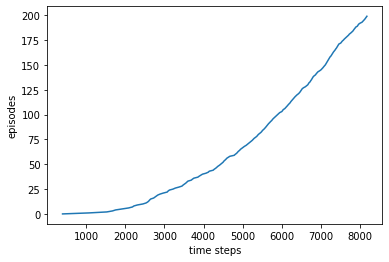

In [11]:
plt.plot(np.cumsum(steps), range(len(steps)))
plt.xlabel('time steps')
plt.ylabel('episodes')
None

Show optimal policy

In [10]:
def dict_to_grid(fun_on_grid: dict, dim: Tuple[int, int]):
    """Plot function on grid"""
    ans = []
    for row in range(dim[0]):
        ans.append({f"col_{col}": fun_on_grid[(row, col)] for col in range(dim[1])})
        
    return pd.DataFrame(ans)

action_to_move = ['up', 'down', 'left', 'rigth']
pi_optim_dict = {windy_env.state_to_grid(state): action_to_move[val] for state, val in enumerate(pi_optim)}
dict_to_grid(pi_optim_dict, dim=windy_env.dim)

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9
0,down,rigth,rigth,rigth,rigth,rigth,rigth,rigth,rigth,down
1,rigth,rigth,left,rigth,up,rigth,rigth,up,up,down
2,rigth,rigth,rigth,rigth,rigth,rigth,down,down,left,down
3,up,up,rigth,rigth,rigth,up,down,down,left,down
4,down,rigth,rigth,rigth,up,rigth,left,down,left,left
5,rigth,rigth,up,rigth,up,down,up,down,left,down
6,down,rigth,rigth,rigth,up,left,rigth,rigth,up,up


### WIth King moves